In [110]:
import propagators
import energy_landscapes
import long_simulation
import weighted_ensemble_2
import numpy as np
import MSM_methods

import matplotlib.pyplot as plt
import importlib

importlib.reload(MSM_methods)
importlib.reload(long_simulation)

#methods for fast print debugging
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

kT = 1
dt = 0.001
system1 = energy_landscapes.unit_double_well()
#system1.plot_quantity(system1.potential)

simulation steps:
 Aggregate: 1000000 
 Molecular: 10000


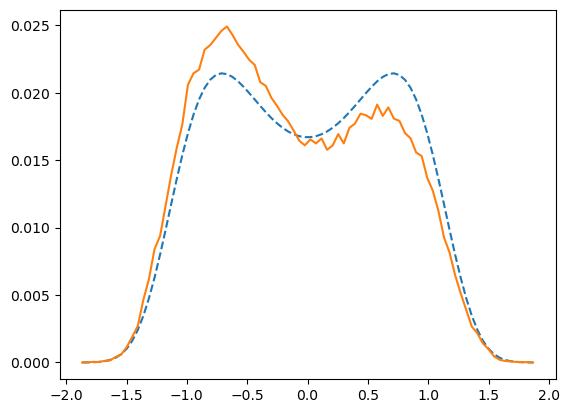

weighted MAE = 0.012120708002644375
MFPT = 828.125+-81.875 steps
eigenvector converged to within 10^-12 after 0 rounds


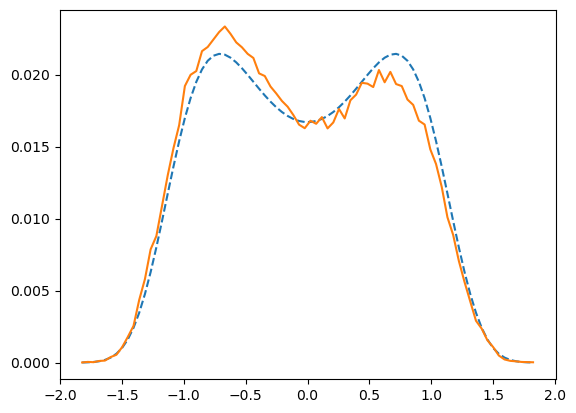

weighted MAE = 0.006946319307108624
MFPT = 651.223991789522+-78.4957839599245 steps
eigenvector converged to within 10^-12 after 0 rounds
[-1.8674100976591548, -1.8213012063589287, -1.7751923150587028, -1.7290834237584767, -1.6829745324582506, -1.6368656411580245, -1.5907567498577986, -1.5446478585575725, -1.4985389672573464, -1.4524300759571203, -1.4063211846568944, -1.3602122933566683, -1.3141034020564422, -1.2679945107562163, -1.2218856194559902, -1.175776728155764, -1.1296678368555382, -1.083558945555312, -1.037450054255086, -0.99134116295486, -0.9452322716546339, -0.8991233803544079, -0.8530144890541818, -0.8069055977539557, -0.7607967064537298, -0.7146878151535037, -0.6685789238532776, -0.6224700325530517, -0.5763611412528256, -0.5302522499525995, -0.48414335865237335, -0.43803446735214746, -0.39192557605192135, -0.34581668475169525, -0.29970779345146936, -0.25359890215124326, -0.20749001085101715, -0.16138111955079104, -0.11527222825056516, -0.06916333695033905, -0.0230544456501

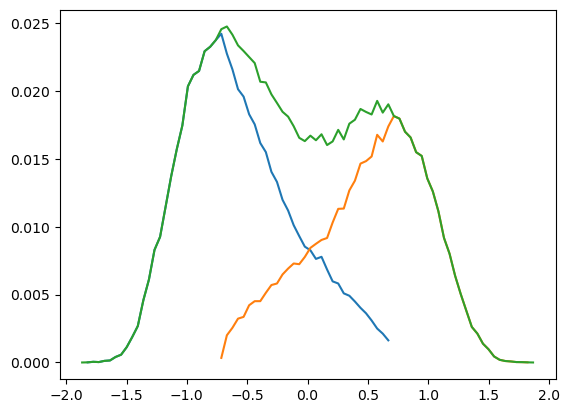

In [111]:
#system1.plot_quantity(system1.potential)
x_init_coord = system1.standard_init_coord()
nsteps = 10000
save_period = 10 #in steps
n_parallel = 100
nbins = 80
lag_time = 1

long_trjs = long_simulation.run_long_parallel_simulations(propagators.propagate_nd, system1, kT, x_init_coord, dt, nsteps, save_period, n_parallel)
print(f"simulation steps:\n Aggregate: {nsteps*n_parallel} \n Molecular: {nsteps}")


#------------------------------------------------------------------------------------------
#non-MSM analysis

x, p, xs, es, xc, ec = long_simulation.estimate_energy_landscape_histogram(long_trjs, kT, nbins)
metrics = energy_landscapes.landscape_comparison(system1, kT, x, p, metrics = ["maew"])
transitions, mfpts = long_simulation.calc_mfpt(system1.macro_class, system1.n_macrostates(), save_period, long_trjs)

inter_well_mpfts = [mfpts[0,1], mfpts[1,0]]
print(f"MFPT = {np.mean(inter_well_mpfts)}+-{np.std(inter_well_mpfts)} steps")


#------------------------------------------------------------------------------------------
#MSM analysis

x_msm, eqp_msm, ms_msm, mfpts_msm = long_simulation.msm_analysis(long_trjs, kT, nbins, system1.macro_class, system1.n_macrostates(), save_period, lag_time=lag_time, show_TPM=False)
metrics = energy_landscapes.landscape_comparison(system1, kT, x_msm, eqp_msm, metrics = ["maew"])
inter_well_mpfts_msm = [mfpts_msm[0,1], mfpts_msm[1,0]]
print(f"MFPT = {np.mean(inter_well_mpfts_msm)}+-{np.std(inter_well_mpfts_msm)} steps")


#------------------------------------------------------------------------------------------
#haMSM analysis
long_simulation.hamsm_analysis(long_trjs, nbins, system1, save_period, lag_time=1, binrange = [], symmetric = True, show_TPM=False)



# WE simulation

In [ ]:
#Weighted ensemble (WE) parameters and inputs

N = 240             #total number of walkers within binrange
nbins = 40         #total number of bins within binrange

walkers_per_bin = round(N/nbins)
print(f"Each bin can hold up to {walkers_per_bin} walkers, for a total of up to {walkers_per_bin*(nbins+2)} walkers")

binrange = [-1.5, 1.5] #progress coordinate range within which to bin simulations
                    #this should extend well past the stall point for examination of the WE stall force
                    #the area past either end of binrange is a bin extending to either + or - inf, yielding a total of nbins+2 bins
n_macrostates=2
        
nsteps = 200        #round length
nrounds = 1000        #number of WE rounds to run

x_init_val = system1.standard_init_coord()

#run weighted ensemble with brownian dynamics
#put this on multiple lines
x_init, e_init, w_init, binbounds, xtrj, etrj, wtrj, transitions, hamsm_transitions, n_trans_by_round \
= weighted_ensemble_2.weighted_ensemble_start(\
                    x_init_val,\
                    nrounds,\
                    nbins,\
                    walkers_per_bin,\
                    binrange, propagators.propagate_nd_save1,\
                    [system1, kT, dt, nsteps],\
                    system1.ensemble_class,\
                    n_macrostates,\
                    ha_binning=False)


aggregate_walkers = len([j for i in xtrj for j in i])
print(f"simulation steps:\n Aggregate: {nsteps*aggregate_walkers} \n Molecular: {nsteps*nrounds}")

x, p, xs, es = weighted_ensemble_2.landscape_recovery(xtrj, wtrj, binbounds, transitions, hamsm_transitions, n_trans_by_round, nrounds, n_macrostates, system1.potential, system1.macro_class, kT)
metrics = energy_landscapes.landscape_comparison(system1, kT, x, p, metrics = ["maew"])



In [ ]:
msm_tpm, states_in_order = MSM_methods.transitions_2_msm(transitions)
msm_eqp = MSM_methods.tpm_2_eqprobs(msm_tpm)

In [ ]:
plt.imshow(msm_tpm)
plt.show()
plt.plot(msm_eqp)